In [1]:
!pip install folium
!pip install geopandas
!pip install contextily
!pip install colormaps

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.9/727.9 kB 3.1 MB/s eta 0:00:00-:--:--

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import folium
import random 

import geopandas as gpd
import contextily as ctx

import networkx as nx
from matplotlib import colormaps

In [4]:
passagers = pd.read_csv("../data_chall_alstom/passagers.csv")
print(passagers.info())
plan_metro = pd.read_csv("../data_chall_alstom/plan_du_métro.csv")
print(plan_metro.info())
position_gps = pd.read_csv("../data_chall_alstom/position_gps_des_stations_de_métro_cleaned.csv")
print(position_gps.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93942 entries, 0 to 93941
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   de      93942 non-null  object
 1   vers    93942 non-null  object
 2   nombre  93942 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   de Ligne      1010 non-null   object
 1   de Station    1010 non-null   object
 2   vers Ligne    1010 non-null   object
 3   vers Station  1010 non-null   object
dtypes: object(4)
memory usage: 31.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Station  307 non-null    object
 1   GPS      307 non-null    object
d

### Mis en forme des jeu de données

In [5]:
plan_metro_ligne = plan_metro[plan_metro["de Station"]!=plan_metro["vers Station"]]
position_gps['lat'], position_gps['lng'] = zip(*position_gps['GPS'].apply(lambda x: x.split(',')))

In [6]:
stations=[]
"""
ligne_nb = list(range(1,15))
ligne_nb=[chr(x) for x in ligne_nb]
ligne_nb.append("3bis")
ligne_nb.append("7bis")
"""
ligne_nb=["1","2","3","3bis","4","5","6","7","8","9","10","11","12","13","14","7bis"]

for ligne in ligne_nb :
    liste_coord=[]
    df_lignei=plan_metro_ligne[plan_metro_ligne["de Ligne"]==ligne]
    station = df_lignei["de Station"].unique()

    for st in station:
        if not(position_gps[position_gps['Station']==st].empty):
            liste_coord.append([float(position_gps[position_gps['Station']==st].iat[0,3]), float(position_gps[position_gps['Station']==st].iat[0,2])])

        
    
    if ligne!="8":
        pop=liste_coord.pop()
        if ligne=="1" :
            liste_coord.insert(0,pop)
    stations.append({'coordinates' : liste_coord, 'type': 'LineString'})

plan_ligne = pd.DataFrame()
plan_ligne["ligne"] = ligne_nb
plan_ligne["station"] = stations

### Representation graphique du reseau

In [7]:
ligne_1=plan_ligne.loc[7]
idf_map = folium.Map(location=[48.868, 2.365], zoom_start=12, tiles='Cartodb dark_matter')


for segment in plan_ligne["station"]:
    gjson = folium.features.GeoJson(segment,
                                    style_function = lambda x: {'color': '#ED6852',
                                                                'weight': 1.5})
    idf_map.add_child(gjson)


for i, v in position_gps.iterrows():
    folium.CircleMarker(location=[v['lat'], v['lng']],
                        radius=1.2,
                        color='#FFFFF0',
                        fill_color='#FFFFFF',
                        fill=True).add_to(idf_map)
idf_map

### Creation de la matrice

In [8]:
import math

#On calcule la distance avec la formule de Haversine
def calcul_distance(station1, station2):
    coord_station1 = position_gps.loc[position_gps["Station"] == station1, "GPS"].iloc[0]
    coord_station2 = position_gps.loc[position_gps["Station"] == station2, "GPS"].iloc[0]
    lat1 , lon1 = map(float, coord_station1.split(", "))
    lat2 , lon2 = map(float, coord_station2.split(", "))
    # Rayon de la Terre en kilomètres
    R = 6371.0
    
    # Convertir les degrés en radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Différences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Formule de Haversine
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    
    # Distance
    distance = R * c
    return distance

def calcul_temps(station1,station2,vitesse):
    return round(calcul_distance(station1,station2)/vitesse*3600)

In [9]:
def creation_matrice(plan_metro, position):
    plan_metro_grouped = plan_metro.groupby("de Station")
    passagers_dict = passagers.set_index(["de", "vers"])["nombre"].to_dict()

    # Liste unique des stations
    liste_station = position["Station"].unique()

    # Initialisation d'un dictionnaire pour construire le graph
    graph_dict = {station: [] for station in liste_station}

    # Construction optimisée du graph
    for depuis in liste_station:
        lien = plan_metro_grouped.get_group(depuis)["vers Station"].unique() if depuis in plan_metro_grouped.groups else []

        # Créer une liste pour chaque station de départ
        for vers in liste_station:
            noeud = {
                "ligne": [],
                "passager": passagers_dict.get((depuis, vers), 0) if depuis != vers else 0
            }

            if vers in lien:
                noeud["ligne"] = list(plan_metro[
                    (plan_metro["de Station"] == depuis) & 
                    (plan_metro["vers Station"] == vers)
                ]["de Ligne"].unique())

            graph_dict[depuis].append(noeud)

    # Conversion en DataFrame
    graph = pd.DataFrame(graph_dict, index=liste_station)
    return graph


In [10]:
df=creation_matrice(plan_metro, position_gps)

In [11]:
df

Boucicaut   
Boucicaut                         {'ligne': [], 'passager': 0}  \
Bourse                            {'ligne': [], 'passager': 3}   
Bir-Hakeim                        {'ligne': [], 'passager': 3}   
Argentine                         {'ligne': [], 'passager': 7}   
Daumesnil                         {'ligne': [], 'passager': 8}   
...                                                        ...   
Lamarck - Caulaincourt            {'ligne': [], 'passager': 2}   
Trinité - d'Estienne d'Orves      {'ligne': [], 'passager': 3}   
Assemblée nationale               {'ligne': [], 'passager': 3}   
Malakoff - Rue Étienne-Dolet      {'ligne': [], 'passager': 8}   
Bibliothèque François-Mitterrand  {'ligne': [], 'passager': 8}   

                                                        Bourse   
Boucicaut                         {'ligne': [], 'passager': 3}  \
Bourse                            {'ligne': [], 'passager': 0}   
Bir-Hakeim                        {'ligne': [], 'passager': 5}   
Argentine                         {'ligne': [], 'passager': 6}   
Daumesnil                         {'ligne': [], 'passager': 6}   
...                                                        ...   
Lamarck - Caulaincourt            {'ligne': [], 'passager': 8}   
Trinité - d'Estienne d'Orves      {'ligne': [], 'passager': 9}   
Assemblée nationale               {'ligne': [], 'passager': 9}   
Malakoff - Rue Étienne-Dolet      {'ligne': [], 'passager': 5}   
Bibliothèque François-Mitterrand  {'ligne': [], 'passager': 9}   

                                                    Bir-Hakeim   
Boucicaut                         {'ligne': [], 'passager': 4}  \
Bourse                            {'ligne': [], 'passager': 2}   
Bir-Hakeim                        {'ligne': [], 'passager': 0}   
Argentine                         {'ligne': [], 'passager': 2}   
Daumesnil                         {'ligne': [], 'passager': 2}   
...                                                        ...   
Lamarck - Caulaincourt            {'ligne': [], 'passager': 8}   
Trinité - d'Estienne d'Orves      {'ligne': [], 'passager': 3}   
Assemblée nationale               {'ligne': [], 'passager': 4}   
Malakoff - Rue Étienne-Dolet      {'ligne': [], 'passager': 3}   
Bibliothèque François-Mitterrand  {'ligne': [], 'passager': 3}   

                                                     Argentine   
Boucicaut                         {'ligne': [], 'passager': 4}  \
Bourse                            {'ligne': [], 'passager': 5}   
Bir-Hakeim                        {'ligne': [], 'passager': 4}   
Argentine                         {'ligne': [], 'passager': 0}   
Daumesnil                         {'ligne': [], 'passager': 5}   
...                                                        ...   
Lamarck - Caulaincourt            {'ligne': [], 'passager': 7}   
Trinité - d'Estienne d'Orves      {'ligne': [], 'passager': 6}   
Assemblée nationale               {'ligne': [], 'passager': 2}   
Malakoff - Rue Étienne-Dolet      {'ligne': [], 'passager': 8}   
Bibliothèque François-Mitterrand  {'ligne': [], 'passager': 8}   

                                                             Daumesnil   
Boucicaut                                 {'ligne': [], 'passager': 3}  \
Bourse                                    {'ligne': [], 'passager': 2}   
Bir-Hakeim                                {'ligne': [], 'passager': 2}   
Argentine                                 {'ligne': [], 'passager': 4}   
Daumesnil                         {'ligne': ['6', '8'], 'passager': 0}   
...                                                                ...   
Lamarck - Caulaincourt                    {'ligne': [], 'passager': 4}   
Trinité - d'Estienne d'Orves              {'ligne': [], 'passager': 5}   
Assemblée nationale                       {'ligne': [], 'passager': 2}   
Malakoff - Rue Étienne-Dolet              {'ligne': [], 'passager': 8}   
Bibliothèque François-Mitterrand          {'ligne': [], 'passager':

In [12]:
def creation_graphe(matrice):
    # Création du graphe avec NetworkX à partir du DataFrame
    G = nx.DiGraph()

    # Ajouter des arêtes au graphe en utilisant les informations du DataFrame
    for start_station in matrice.index:
        for end_station in matrice.columns:
            connection = matrice.loc[start_station, end_station]
            if connection['ligne']!=[] and start_station != end_station:
                G.add_edge(start_station, end_station,
                        lines=connection['ligne'],
                        passagers=connection["passager"])
    # Visualisation (optionnel)
    for i, node in position_gps.iterrows():
        G.add_node(node["Station"], pos=(float(node["lng"]), float(node["lat"]))) 
    return G

In [13]:
G_metro = creation_graphe(df)

In [14]:
G_metro.number_of_edges()

754

In [15]:
nx.is_strongly_connected(G_metro)

True

In [16]:
def afficher_graph(G_metro):
    # Récupérer les positions des nœuds pour NetworkX
    pos=nx.get_node_attributes(G_metro, "pos")

    # Convertir les positions en GeoDataFrame pour reprojection
    gdf_nodes = gpd.GeoDataFrame(
        {"name": list(pos.keys())},
        geometry=gpd.points_from_xy([position[0] for position in pos.values()], [position[1] for position in pos.values()]),
        crs="EPSG:4326",  # WGS84 (latitude/longitude)
    )

    # Reprojeter en EPSG:3857 (Web Mercator)
    gdf_nodes = gdf_nodes.to_crs(epsg=3857)
    positions_3857 = {row["name"]: (row.geometry.x, row.geometry.y) for _, row in gdf_nodes.iterrows()}

    # Calcul des largeurs des arêtes (en fonction des passagers)
    passager_values = [data["passagers"] for _, _, data in G_metro.edges(data=True)]
    norm = Normalize(vmin=min(passager_values), vmax=max(passager_values), clip=True)
    cmap = colormaps["plasma"]
    edge_colors = [cmap(norm(data["passagers"])) for _, _, data in G_metro.edges(data=True)]

    # Préparer la figure
    fig, ax = plt.subplots(figsize=(12, 10))

    # Ajouter les nœuds et les arêtes au graphe
    nx.draw(
        G_metro,
        pos=positions_3857,  # Utiliser les coordonnées reprojetées
        with_labels=False,
        node_color="lightblue",
        edge_color=edge_colors,
        node_size=20,
        font_size=10,
        width=1.7,
        ax=ax,
    )

    # Ajouter un fond de carte
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Afficher la carte
    plt.title("Graphe des flux de passagers du métro parisien", fontsize=16)
    plt.show()

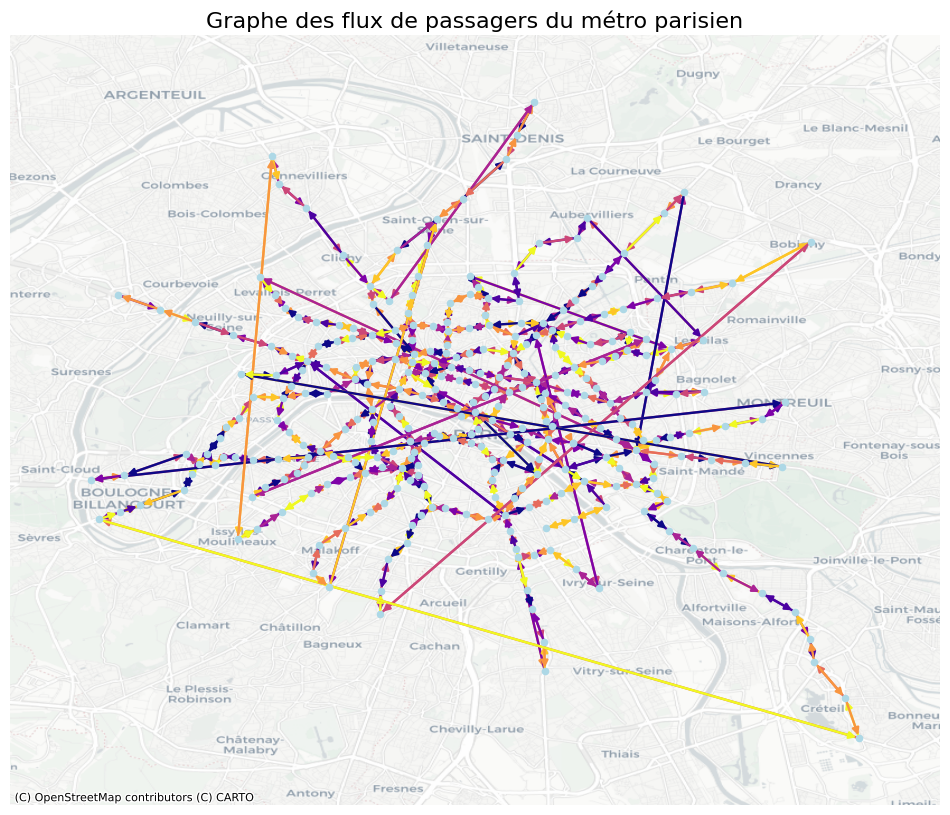

In [17]:
afficher_graph(G_metro)

In [ ]:
# Liste des stations à exclure
stations_exclues = [
    "Charles de Gaulle - Étoile", "Champs-Élysées - Clemenceau", "Palais-Royal - Musée du Louvre",
    "Reuilly - Diderot", "Barbès - Rochechouart", "Havre - Caumartin", "Réaumur - Sébastopol",
    "Marcadet - Poissonniers", "Montparnasse - Bienvenüe", "Bobigny - Pablo Picasso",
    "La Motte-Picquet - Grenelle", "Richelieu - Drouot", "Bonne-Nouvelle", "Sèvres - Babylone",
    "Châtillon - Montrouge", "Louvre - Rivoli", "Pereire", "Quatre-Septembre", "Richard-Lenoir",
    "Bréguet - Sabin", "Campo-Formio", "Sèvres - Lecourbe", "Aubervilliers - Pantin - Quatre Chemins",
    "Pont-Neuf", "Sully - Morland", "Censier - Daubenton", "Villejuif - Paul Vaillant-Couturier",
    "Pré-Saint-Gervais", "La Tour-Maubourg", "Saint-Sébastien - Froissart", "Ledru-Rollin",
    "Faidherbe - Chaligny", "École vétérinaire de Maisons-Alfort", "Maisons-Alfort - Les Juilliottes",
    "Créteil - L'Échat", "Créteil - Université", "Créteil - Préfecture", "Chardon-Lagache",
    "Avenue Émile-Zola", "Cluny - La Sorbonne", "Maubert - Mutualité", "Lamarck - Caulaincourt",
    "Trinité - d'Estienne d'Orves", "Assemblée nationale", "Malakoff - Rue Étienne-Dolet","Château Rouge",
    "Bibliothèque François-Mitterrand","Cambronne","École Militaire","Grands Boulevards","Maisons-Alfort - Stade","Jules Joffrin","Olympiades"
]

# Filtrer les données pour exclure ces stations
passagers_filtre = passagers[
    ~passagers['de'].isin(stations_exclues) & ~passagers['vers'].isin(stations_exclues)
]

# Afficher les données filtrées
print(passagers_filtre)

                       de                          vers  nombre
0              La Défense       Esplanade de La Défense       7
1              La Défense               Pont de Neuilly       5
2              La Défense                   Les Sablons       6
3              La Défense                 Porte Maillot       6
4              La Défense                     Argentine       5
...                   ...                           ...     ...
93321  Cour Saint-Émilion                     Plaisance       7
93322  Cour Saint-Émilion               Porte de Vanves       8
93323  Cour Saint-Émilion  Malakoff - Plateau de Vanves       3
93326  Cour Saint-Émilion                    Saint-Ouen       6
93327  Cour Saint-Émilion                 Pont Cardinet       2

[64262 rows x 3 columns]


In [18]:
from collections import defaultdict

def calculer_flux_passagers(graphe, donnees):
    """
    Calcule le flux de passagers à travers un graphe en fonction des données de trajet.
    Chaque flux directionnel est traité séparément sans addition dans l'autre sens.
    
    :param graphe: Graph NetworkX représentant le réseau de transport.
    :param donnees: Liste de tuples (gare_depart, gare_arrivee, nombre_passagers).
    :return: Deux dictionnaires contenant les flux par nœud et par arête.
    """
    # Initialisation des flux
    flux_par_noeud = defaultdict(int)
    flux_par_arete = defaultdict(int)

    # Calcul des trajets pour chaque donnée
    for gare_depart, gare_arrivee, nombre_passagers in donnees:
        try:
            # Trouver le chemin le plus court
            chemin = nx.shortest_path(graphe, source=gare_depart, target=gare_arrivee)
            
            # Ajouter les passagers à chaque nœud et arête du chemin
            for i in range(len(chemin)):
                # Ajouter au flux du nœud
                flux_par_noeud[chemin[i]] += nombre_passagers
                if i < len(chemin) - 1:
                    # Ajouter au flux de l'arête (en gardant la direction distincte)
                    u, v = chemin[i], chemin[i + 1]
                    flux_par_arete[(u, v)] += nombre_passagers
        except nx.NetworkXNoPath:
            pass
            #print(f"Pas de chemin entre {gare_depart} et {gare_arrivee}.")

    # Créer une matrice d'adjacence sous forme de DataFrame
    noeuds = list(graphe.nodes)
    matrice_flux = pd.DataFrame(0, index=noeuds, columns=noeuds)

    # Remplir la matrice avec les flux
    for (u, v), flux in flux_par_arete.items():
        matrice_flux.loc[u, v] = flux
    return flux_par_noeud, matrice_flux

In [ ]:
"""
# Exemple d'utilisation
if __name__ == "__main__":
   
   
    donnees = list(passagers_filtre[['de', 'vers', 'nombre']].itertuples(index=False, name=None))

    # Calcul des flux
    flux_noeuds, flux_aretes = calculer_flux_passagers(G_metro, donnees)

    # Afficher les résultats
    #print("Flux par nœud :")
    #for noeud, flux in flux_noeuds.items():
    #    print(f"{noeud} : {flux}")
#
    #print("\nFlux par arête :")
    #for arete, flux in flux_aretes.items():
    #    print(f"{arete} : {flux}")

# Convertir les résultats en DataFrame
flux_noeuds_df = pd.DataFrame(list(flux_noeuds.items()), columns=['Noeud', 'Flux'])
flux_aretes_df = pd.DataFrame(list(flux_aretes.items()), columns=['Arete', 'Flux'])

# Ajouter des colonnes pour les nœuds de départ et d'arrivée dans le DataFrame des arêtes
flux_aretes_df[['Noeud_depart', 'Noeud_arrivee']] = pd.DataFrame(flux_aretes_df['Arete'].tolist(), index=flux_aretes_df.index)
flux_aretes_df = flux_aretes_df.drop(columns=['Arete'])

# Enregistrer les DataFrames dans des fichiers CSV
flux_noeuds_df.to_csv("flux_par_noeud.csv", index=False, encoding="utf-8")
flux_aretes_df.to_csv("flux_par_arete.csv", index=False, encoding="utf-8") 
"""

In [39]:
donnees = list(passagers[['de', 'vers', 'nombre']].itertuples(index=False, name=None))
flux_noeuds, matrice_flux = calculer_flux_passagers(G_metro, donnees)

In [40]:
matrice_flux

Boucicaut  Félix Faure  Lourmel  Bourse   
Boucicaut                             0        10692    10036       0  \
Félix Faure                       10528            0        0       0   
Lourmel                           10203            0        0       0   
Bourse                                0            0        0       0   
Sentier                               0            0        0    1532   
...                                 ...          ...      ...     ...   
Avenue Émile-Zola                     0            0        0       0   
Malakoff - Rue Étienne-Dolet          0            0        0       0   
Faidherbe - Chaligny                  0            0        0       0   
Créteil - L'Échat                     0            0        0       0   
Créteil - Université                  0            0        0       0   

                              Sentier  Quatre-Septembre  Bir-Hakeim  Passy   
Boucicaut                           0                 0           0      0  \
Félix Faure                         0                 0           0      0   
Lourmel                             0                 0           0      0   
Bourse                           1505              2238           0      0   
Sentier                             0                 0           0      0   
...                               ...               ...         ...    ...   
Avenue Émile-Zola                   0                 0           0      0   
Malakoff - Rue Étienne-Dolet        0                 0           0      0   
Faidherbe - Chaligny                0                 0           0      0   
Créteil - L'Échat                   0                 0           0      0   
Créteil - Université                0                 0           0      0   

                              Dupleix  Argentine  ...   
Boucicaut                           0          0  ...  \
Félix Faure                         0          0  ...   
Lourmel                             0          0  ...   
Bourse                              0          0  ...   
Sentier                             0          0  ...   
...                               ...        ...  ...   
Avenue Émile-Zola                   0          0  ...   
Malakoff - Rue Étienne-Dolet        0          0  ...   
Faidherbe - Chaligny                0          0  ...   
Créteil - L'Échat                   0          0  ...   
Créteil - Université                0          0  ...   

                              Aubervilliers - Pantin - Quatre Chemins   
Boucicaut                                                           0  \
Félix Faure                                                         0   
Lourmel                                                             0   
Bourse                                                              0   
Sentier                                                             0   
...                                                               ...   
Avenue Émile-Zola                                                   0   
Malakoff - Rue Étienne-Dolet                                        0   
Faidherbe - Chaligny                                                0   
Créteil - L'Échat                                                   0   
Créteil - Université                                                0   

                              Porte de la Villette  Porte de la Chapelle   
Boucicaut                                        0                     0  \
Félix Faure                                      0                     0   
Lourmel                                          0                     0   
Bourse                                           0                     0   
Sentier                                          0                     0   
...                                            ...                   ...   
Avenue Émile-Zola                                0                     0   
Malakoff - Rue Étienne-Dolet                  

In [27]:
flux_noeuds

defaultdict(int,
            {'La Défense': 3077,
             'Esplanade de La Défense': 6155,
             'Pont de Neuilly': 9176,
             'Les Sablons': 12175,
             'Porte Maillot': 15205,
             'Argentine': 18099,
             'Charles de Gaulle - Étoile': 63459,
             'George V': 22024,
             'Franklin D. Roosevelt': 39058,
             'Champs-Élysées - Clemenceau': 28050,
             'Concorde': 51987,
             'Tuileries': 4895,
             'Palais-Royal - Musée du Louvre': 5364,
             "Place d'Italie": 64916,
             'Campo-Formio': 19932,
             'Saint-Marcel': 20810,
             "Gare d'Austerlitz": 33485,
             'Châtelet': 120593,
             'Louvre - Rivoli': 3093,
             'Hôtel de Ville': 25566,
             'Quai de la Rapée': 7440,
             'Bastille': 21883,
             'Saint-Paul': 3294,
             'Nationale': 18587,
             'Chevaleret': 18473,
             'Quai de la Gare': 196

In [31]:
def creation_graphe(matrice):
    # Création du graphe avec NetworkX à partir du DataFrame
    G = nx.DiGraph()

    # Ajouter des arêtes au graphe en utilisant les informations du DataFrame
    for start_station in matrice.index:
        for end_station in matrice.columns:
            connection = matrice.loc[start_station, end_station]
            if connection['ligne']!=[] and start_station != end_station:
                G.add_edge(start_station, end_station,
                        lines=connection['ligne'],
                        passagers=connection["passager"])
    # Visualisation (optionnel)
    for i, node in position_gps.iterrows():
        G.add_node(node["Station"], pos=(float(node["lng"]), float(node["lat"]))) 
    return G

In [37]:
def graph_flux(matrice_flux, positions):
   
    G = nx.DiGraph()

    # Remplir le graphe avec les flux directionnels
    for u in matrice_flux.index:
        for v in matrice_flux.columns:
            flux = matrice_flux.loc[u, v]
            if flux > 0:  # Ajouter uniquement les relations avec un flux positif
                G.add_edge(u, v, passager=flux)

    # Ajouter les positions des stations
    for _, node in positions.iterrows():
        G.add_node(node["Station"], pos=(float(node["lng"]), float(node["lat"])))

    # Récupérer les positions des nœuds pour NetworkX
    pos = nx.get_node_attributes(G, "pos")

    # Convertir les positions en GeoDataFrame pour reprojection
    gdf_nodes = gpd.GeoDataFrame(
        {"name": list(pos.keys())},
        geometry=gpd.points_from_xy([p[0] for p in pos.values()], [p[1] for p in pos.values()]),
        crs="EPSG:4326",  # WGS84 (latitude/longitude)
    )

    # Reprojeter en EPSG:3857 (Web Mercator)
    gdf_nodes = gdf_nodes.to_crs(epsg=3857)
    positions_3857 = {row["name"]: (row.geometry.x, row.geometry.y) for _, row in gdf_nodes.iterrows()}

    # Calcul des largeurs des arêtes (en fonction des passagers)
    passager_values = [data["passager"] for _, _, data in G.edges(data=True)]
    if passager_values:  # Vérifier qu'il y a des valeurs pour normaliser
        norm = Normalize(vmin=min(passager_values), vmax=max(passager_values), clip=True)
        cmap = colormaps["plasma"]
        edge_colors = [cmap(norm(data["passager"])) for _, _, data in G.edges(data=True)]
    else:
        edge_colors = []  # Pas de flux

    # Préparer la figure
    fig, ax = plt.subplots(figsize=(12, 10))

    # Ajouter les nœuds et les arêtes au graphe
    nx.draw(
        G,
        pos=positions_3857,  # Utiliser les coordonnées reprojetées
        connectionstyle="arc3,rad=-0.1",
        with_labels=False,
        node_color="lightblue",
        edge_color=edge_colors,
        node_size=20,
        font_size=10,
        width=1.7,
        ax=ax,
    )

    # Ajouter un fond de carte
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Afficher la carte
    plt.title("Graphe des flux de passagers du métro parisien", fontsize=16)
    plt.show()

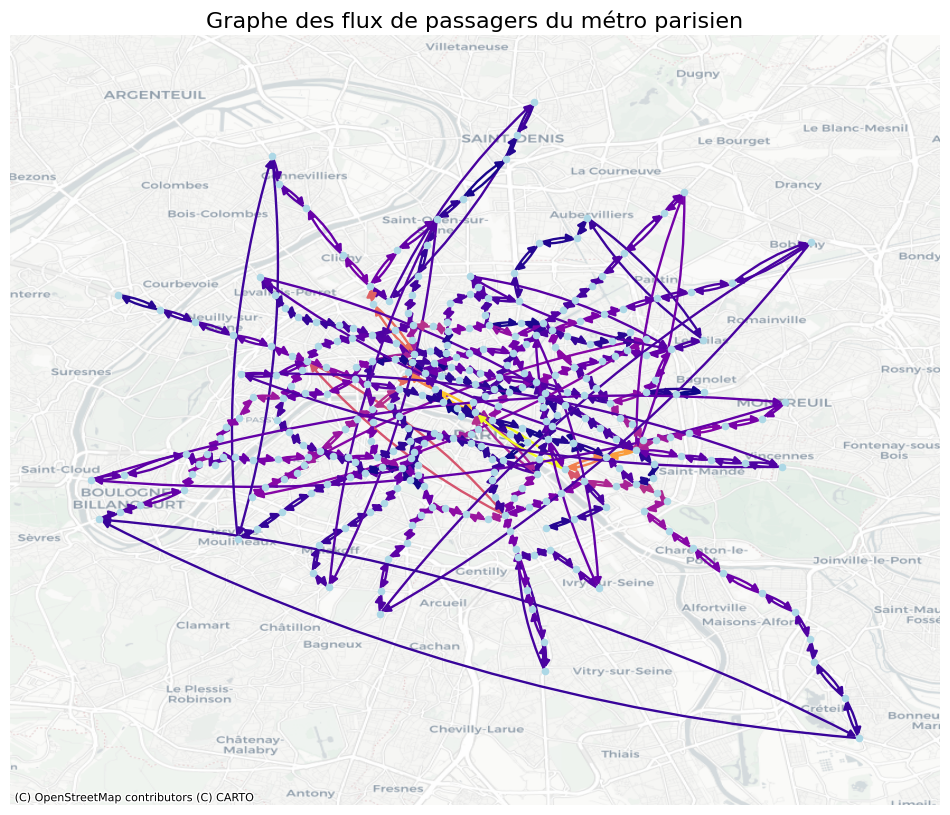

In [41]:
graph_flux(matrice_flux, position_gps)


In [42]:
def nombre_chemin(station1,station2, G):
    # Trouver tous les chemins entre Station_A et Station_F
    all_paths = list(nx.all_simple_paths(G, source=station1, target=station2))
    # Afficher les chemins avec des nformations détaillées
    return (len(all_paths))

In [58]:
nombre_chemin("Madeleine", "Invalides", G_metro)

KeyboardInterrupt: 

In [75]:
def limited_simple_paths(graph, source, target, max_paths=None):
    """
    Trouve un nombre limité de chemins simples entre deux nœuds.
    
    :param graph: Graphe NetworkX
    :param source: Nœud de départ
    :param target: Nœud d'arrivée
    :param max_paths: Nombre maximum de chemins à trouver (None = tous les chemins simples)
    :return: Liste des chemins trouvés
    """
    def dfs(current_node, path):
        # Si le nœud cible est atteint, ajouter le chemin à la liste
        if current_node == target:
            paths.append(list(path))
            return len(paths) >= max_paths if max_paths else False  # Arrêter si max_paths atteint
        
        # Explorer les voisins non visités
        for neighbor in graph.neighbors(current_node):
            if neighbor not in path:
                path.append(neighbor)
                if dfs(neighbor, path):  # Si le max est atteint, arrêter l'exploration
                    return True
                path.pop()
        return False

    paths = []
    dfs(source, [source])
    return len(paths)

# Exemple d'utilisation
G = nx.Graph()
G.add_edges_from([
    ("A", "B"), ("A", "C"), ("B", "D"), ("C", "D"), ("C", "E"), ("D", "E")
])

source = "A"
target = "E"
max_paths = 2  # Trouver au maximum 2 chemins simples

found_paths = limited_simple_paths(G_metro, "Garibaldi", "Créteil - Préfecture", max_paths=max_paths)
print(f"Chemins trouvés entre {source} et {target} : {found_paths}")

Chemins trouvés entre A et E : 2


In [43]:
df_ligne_insuppressible = pd.DataFrame(columns=['de Ligne','de Station', 'vers Ligne', 'vers Station'])
df_ligne_suppressible = pd.DataFrame(columns=['de Ligne','de Station', 'vers Ligne', 'vers Station'])

In [53]:
compteur = 0
for index, row in plan_metro.iterrows():
    print(row)  
    stationDe = row['de Station']
    stationVers = row['vers Station']
    if stationDe != stationVers and stationDe in G_metro and stationVers in G_metro:
        print("re")
        # Appelez la fonction pour obtenir le nombre de chemins
        nb_chemin = nombre_chemin(stationDe, stationVers, G_metro)
        print(f"Nombre de chemins entre {stationDe} et {stationVers}: {nb_chemin}")
        if nb_chemin > 1:
            compteur += 1
            df_ligne_suppressible.loc[len(df_ligne_suppressible)]=row
        else :
            print(len(df_ligne_insuppressible))
            df_ligne_insuppressible.loc[len(df_ligne_insuppressible)]=row
    else :
        df_ligne_insuppressible.loc[len(df_ligne_insuppressible)]=row
print('Nb_arete suppressible:',compteur)

de Ligne                                 1
de Station      Charles de Gaulle - Étoile
vers Ligne                               2
vers Station    Charles de Gaulle - Étoile
Name: 0, dtype: object
de Ligne                                 1
de Station      Charles de Gaulle - Étoile
vers Ligne                               6
vers Station    Charles de Gaulle - Étoile
Name: 1, dtype: object
de Ligne                            1
de Station      Franklin D. Roosevelt
vers Ligne                          9
vers Station    Franklin D. Roosevelt
Name: 2, dtype: object
de Ligne                                  1
de Station      Champs-Élysées - Clemenceau
vers Ligne                               13
vers Station    Champs-Élysées - Clemenceau
Name: 3, dtype: object
de Ligne               1
de Station      Concorde
vers Ligne             8
vers Station    Concorde
Name: 4, dtype: object
de Ligne               1
de Station      Concorde
vers Ligne            12
vers Station    Concorde
Name: 5, dtyp

KeyboardInterrupt: 

In [ ]:
print(len(df_ligne_insuppressible))
print(len(df_ligne_suppressible))

756
254


In [48]:
def generate_one_problem():
    # Étape 1 : Nombre aléatoire de lignes cassées à simuler
    nb_lignes_cassees = random.randint(1,1)
    ##nb_lignes_cassees = random.randint(1, df_ligne_suppressible)

    lignes_cassees = df_ligne_suppressible.sample(nb_lignes_cassees)

    # Étape 3 : Créer le DataFrame final
    lignes_restantes = pd.concat([df_ligne_suppressible, lignes_cassees]).drop_duplicates(keep=False)

    # Combiner avec les lignes insuppressibles
    df_final = pd.concat([df_ligne_insuppressible, lignes_restantes], ignore_index=True)

    """# Affichage des résultats
    print("Lignes insuppressibles :")
    print(df_ligne_insuppressible)
    print("\nLignes suppressibles (complètes) :")
    print(df_ligne_suppressible)
    print(f"\nLignes cassées (aléatoires, {nb_lignes_cassees} lignes) :")
    print(lignes_cassees)
    print("\nDataFrame final combiné :")
    print(df_final)"""
    return df_final

In [ ]:
def faire_matrice_flux(matrice_graphe,matrice_flux_origine):
    graphe = creation_graphe(matrice_graphe)
    _ , matrice_nouveau_flux = calculer_flux_passagers(graphe, donnees)
    # Calcul de la variation en pourcentage
    variation_flux = (matrice_nouveau_flux - matrice_flux_origine) / matrice_flux_origine * 100
    
    # Gérer les cas où matrice_flux_origine a des zéros pour éviter les divisions par zéro
    variation_flux = variation_flux.fillna(0)  # Remplace NaN par 0 dans les cas où origine = 0
    return variation_flux

In [ ]:
variation_flux = faire_matrice_flux(creation_matrice(generate_one_problem(),position_gps),matrice_flux)

In [ ]:
# Option pour afficher toutes les lignes
pd.set_option('display.max_rows', None)

# Option pour afficher toutes les colonnes
pd.set_option('display.max_columns', None)

# Afficher le DataFrame en entier
print(variation_flux)

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

                                    Boucicaut  Félix Faure  Lourmel  Bourse  \
Boucicaut                                 0.0          0.0      0.0     0.0   
Félix Faure                               0.0          0.0      0.0     0.0   
Lourmel                                   0.0          0.0      0.0     0.0   
Bourse                                    0.0          0.0      0.0     0.0   
Sentier                                   0.0          0.0      0.0     0.0   
Bir-Hakeim                                0.0          0.0      0.0     0.0   
Passy                                     0.0          0.0      0.0     0.0   
Dupleix                                   0.0          0.0      0.0     0.0   
Argentine                                 0.0          0.0      0.0     0.0   
Porte Maillot                             0.0          0.0      0.0     0.0   
Daumesnil                                 0.0          0.0      0.0     0.0   
Dugommier                                 0.0       

In [46]:
def generate_train_dataset(n):
    train_dataset = []
    for _ in range (n):
        graph_generer=creation_matrice(generate_one_problem(),position_gps)
        train_dataset.append((generate_one_problem(),faire_matrice_flux(graph_generer,matrice_flux)))
    return train_dataset

In [49]:
dataset_train1 = generate_train_dataset(10)

ValueError: a must be greater than 0 unless no samples are taken

In [ ]:
dataset_train1[7]

(     de Ligne                   de Station vers Ligne  \
 0           1   Charles de Gaulle - Étoile          2   
 1           1   Charles de Gaulle - Étoile          6   
 2           1        Franklin D. Roosevelt          9   
 3           1  Champs-Élysées - Clemenceau         13   
 4           1                     Concorde          8   
 ...       ...                          ...        ...   
 1004       14                 Saint-Lazare         14   
 1005       14                    Madeleine         14   
 1006       14                    Pyramides         14   
 1007       14                     Châtelet         14   
 1008       14                 Gare de Lyon         14   
 
                      vers Station  
 0      Charles de Gaulle - Étoile  
 1      Charles de Gaulle - Étoile  
 2           Franklin D. Roosevelt  
 3     Champs-Élysées - Clemenceau  
 4                        Concorde  
 ...                           ...  
 1004                    Madeleine  
 1005 

In [ ]:
pd.DataFrame(dataset_train1, columns=["plan_metro_degradé", "flux_dégradé"]).to_csv('dataset_train.csv', index=False)